In [67]:
pip install transformers sentence-transformers

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pickle
from IPython.display import clear_output
from transformers import DistilBertTokenizer, DistilBertModel

In [70]:
root_folder = '/content/drive/MyDrive/DL_Assignments/DL_A3'
data_folder = f'{root_folder}/data'
weights_folder = f'{root_folder}/weights'
plots_folder = f'{root_folder}/plots'

In [71]:
os.chdir(root_folder)

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [73]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

## Loading and Processing Data

In [74]:
def load_and_clean_data(file_name) :
    global data_folder
    data = pd.read_csv(f'{data_folder}/{file_name}', sep ="\t")
    data_X = data.drop(['Entity', 'Four-class labels', 'Binary labels'], axis = 1).to_numpy()
    data_y = data['Binary labels'].to_numpy()

    return data_X, data_y

In [75]:
train_X, train_y = load_and_clean_data('PARADE_train.txt')

In [76]:
print(train_X, train_y, sep = "\n")

[['predictive models are involved with predicting a value based on other values in the dataset. the process of training a predictive model is known as supervised learning.'
  'predict a value based on other values in the dataset. process of training a pred model is supervised learning.']
 ['predict a value based on other values in the dataset. process of training a pred model is supervised learning.'
  'involved with predicting a value based on other values in the dataset; process of training this type of model is known as supervised learning']
 ['predicting one value (the target variable) using other values'
  'predictive models are involved with predicting a value based on other values in the dataset.']
 ...
 ['calculates the shortest route from a source to a destination through a network and is restricted to follow a linear network'
  'network analysis is used in many different applications. four are highlighted here:  optimal routes closest facility service areas origin-destination

In [77]:
val_X, val_y = load_and_clean_data('PARADE_validation.txt')
print(val_X, val_y, sep = "\n")

[['time elapsed between clock readings' 'math symbol: Δt (delta t)']
 ['how much time it takes for something to happen. symbol: Δt units: s (seconds)'
  'elapsed time, or the time that has gone by']
 ["a knowledge based system that acts on a user's behalf to accomplish specific tasks"
  '-special purpose knowledge based info system  -shopping bot']
 ...
 ["first set of activities in the up's design discipline;involve selecting and describing the configuration of all hardware, network, systems software, and application development tools to support system development and operations"
  'the process that selects and describes the exact configuration of all hardware, network, system software, application development tools to support system development and operations.']
 ['where you identify the overall structure of the system , the principal components , their relationships and how they are distributed.'
  'where you identify the structure of the system, the principal components, and how th

In [78]:
test_X, test_y = load_and_clean_data('PARADE_test.txt')
print(test_X, test_y, sep = "\n")

[['must be both relevant and accurate to achieve optimal results'
  'a list of all external data needed for the use case to be performed']
 ['-any data that the program receives while it is running -from file or user input -is typically &"un-meaningful&" until &"processed&" -data that is typed on a keyboard'
  'the data values that are scanned by a program']
 ["vulnerability exists but wasn't detected by vulnerability scanner"
  "a security incident that isn't detected or reported. as an example, occurs if an attack is active on the network but the nids does not raise an alert."]
 ...
 ['- needs to be managed - should be a formal process - need policies for when a key is breached, misused'
  'involves proper storing and management of keys. certain types of environments (pci-dss) require strict procedures. cryptographic keys. physical, logical, and personnel security keys.']
 ['method of properly issuing, maintaining and organizing encryption keys.'
  'the methods for creating and manag

In [79]:
train_size = 300
val_size = 300
test_size = 300

train_X = train_X[:train_size]
train_y = train_y[:train_size]

val_X = val_X[:val_size]
val_y = val_y[:val_size]

test_X = test_X[:test_size]
test_y = test_y[:test_size]

In [80]:
print(train_X.shape, val_X.shape, test_X.shape)

(300, 2) (300, 2) (300, 2)


## Data Visualisation

In [81]:
def plot_multi_bars(values, labels, title, xlabel, ylabel, xticks, save = False) : 
    width = 0.2

    n = values.shape[1]
    indexes = np.arange(n)
    fig, ax = plt.subplots()
    for i in range(n) :
        ax.bar(indexes + i * width, values[:,i], width, label = labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(indexes + width * n / 2 - 0.1, xticks)
    ax.legend(loc = 'best')
    if save is not None:
        plt.savefig(f"{root_folder}/{title}.png")
    plt.show()

In [82]:
def plot_bars(values, labels, title, xlabel, ylabel, save = False) :
    plt.bar(labels, values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save is not None:
        plt.savefig(f"{root_folder}/{title}.png")
    plt.show()

### Analysing Sentence Length

In [83]:
def get_sentence_length(data) :
    np_len = np.vectorize(lambda x: len(x))
    lengths = np_len(data)

    return lengths

In [84]:
# train_X_sen_lens = get_sentence_length(train_X)
# val_X_sen_lens = get_sentence_length(val_X)
# test_X_sen_lens = get_sentence_length(test_X)

In [85]:
# train_X_max_len = np.max(train_X_sen_lens)
# val_X_max_len = np.max(val_X_sen_lens)
# test_X_max_len = np.max(test_X_sen_lens)

# max_lens = (train_X_max_len, val_X_max_len, test_X_max_len)

In [86]:
# train_X_min_len = np.min(train_X_sen_lens)
# val_X_min_len = np.min(val_X_sen_lens)
# test_X_min_len = np.min(test_X_sen_lens)

# min_lens = (train_X_min_len, val_X_min_len, test_X_min_len)

In [87]:
# train_X_avg_len = np.sum(train_X_sen_lens) / (train_X_sen_lens.shape[0] * train_X_sen_lens.shape[1])
# val_X_avg_len = np.sum(val_X_sen_lens) / (val_X_sen_lens.shape[0] * val_X_sen_lens.shape[1])
# test_X_avg_len = np.sum(test_X_sen_lens) / (test_X_sen_lens.shape[0] * test_X_sen_lens.shape[1])

# avg_lens = (train_X_avg_len, val_X_avg_len, test_X_avg_len)

In [88]:
# sen_lens = np.array(list(zip(max_lens, avg_lens, min_lens)))
# sen_lens

In [89]:
# plot_multi_bars(sen_lens, np.array(['Max', 'Avg', 'Min']), 'Analysing Sentence Lengths', 'Data', 'Lengths', np.array(['Train', 'Val', 'Test']), True)

### Analysing Words Count

In [90]:
def get_words_count(data) :
    np_len = np.vectorize(lambda x: len(x.split()))
    counts = np_len(data)

    return counts

In [91]:
# train_X_words_count = get_words_count(train_X)
# val_X_words_count = get_words_count(val_X)
# test_X_words_count = get_words_count(test_X)

In [92]:
# train_X_max_words_count = np.max(train_X_words_count)
# val_X_max_words_count = np.max(val_X_words_count)
# test_X_max_words_count = np.max(test_X_words_count)

# max_words_count = (train_X_max_words_count, val_X_max_words_count, test_X_max_words_count)

In [93]:
# train_X_min_words_count = np.min(train_X_words_count)
# val_X_min_words_count = np.min(val_X_words_count)
# test_X_min_words_count = np.min(test_X_words_count)

# min_words_count = (train_X_min_words_count, val_X_min_words_count, test_X_min_words_count)

In [94]:
# train_X_avg_words_count = np.sum(train_X_words_count) / (train_X_words_count.shape[0] * train_X_words_count.shape[1])
# val_X_avg_words_count = np.sum(val_X_words_count) / (val_X_words_count.shape[0] * val_X_words_count.shape[1])
# test_X_avg_words_count = np.sum(test_X_words_count) / (test_X_words_count.shape[0] * test_X_words_count.shape[1])

# avg_words_count = (train_X_avg_words_count, val_X_avg_words_count, test_X_avg_words_count)

In [95]:
# words_count = np.array(list(zip(max_words_count, avg_words_count, min_words_count)))
# words_count

In [96]:
# plot_multi_bars(words_count, np.array(['Max', 'Avg', 'Min']), 'Analysing Words Count', 'Data', 'Lengths', np.array(['Train', 'Val', 'Test']), True)

### Analysing Cosine Similarities

In [97]:
def get_cosine_similarity(data, label, model) :
    n = data.shape[0]
    paraphrased_similarity = 0
    paraphrased_count = 0
    unparaphrased_similarity = 0
    unparaphrased_count = 0

    for i in range(n) :
        sen1, sen2 = model.encode(data[i])
        cs = cosine_similarity( [sen1], [sen2] )
        if label[i] == 1 :
            paraphrased_similarity += cs
            paraphrased_count += 1
        else :
            unparaphrased_similarity += cs
            unparaphrased_count += 1
    
    paraphrased_similarity /= paraphrased_count
    unparaphrased_similarity /= unparaphrased_count

    return (paraphrased_similarity[0][0], unparaphrased_similarity[0][0])

In [98]:
# model = SentenceTransformer('bert-base-nli-mean-tokens')

In [99]:
# train_cosine_similarity = get_cosine_similarity(train_X, train_y, model)

In [100]:
# train_cosine_similarity

In [101]:
# plot_bars(train_cosine_similarity, np.array(['Paraphrased', 'Unparaphrased']), 'Senetences', 'Cosine Similarity', 'Senetences v/s Cosine Similarity', True)

## Creating Dataloader

In [102]:
class MyModelDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = X
        self.y = y

        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):

        sent1 = self.X[idx][0]
        sent2 = self.X[idx][1]
        label = self.y[idx]

        encodes = self.tokenizer(sent1, sent2, add_special_tokens = True, padding = 'max_length', return_tensors = 'pt')
        encodes['input_ids'] = encodes['input_ids'].squeeze(0)

        label = torch.tensor(label, dtype = torch.float32)

        return {'encodes': encodes, 'label': label}

## Creating Model

In [103]:
class MyModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config

        self.distilbert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        self.fc1 = nn.Linear(768, 64)
        self.fc2 = nn.Linear(768, 64)
        self.fc3 = nn.Linear(768, 64)
        self.multihead_attn = nn.MultiheadAttention(64, 2)

        self.lstm = nn.LSTM(64, 128, batch_first = True, bidirectional = True)
        self.fc4 = nn.Linear(128, 1)

        self.sig = nn.Sigmoid()

        if config['attention_freeze'] == 'all' : #freeze all layers
            for param in self.multihead_attn.parameters():
                param.requires_grad = False
        elif config['attention_freeze'] == 'some' : #freeze some layer
            count = 0 #total 4 layers in attention block
            for param in self.multihead_attn.parameters():
                if count < 2 :
                    param.requires_grad = False
                    count += 1
                else:
                    break

    def forward(self, X):
        # embeddings
        X = self.distilbert_model(**X).last_hidden_state
        
        X_query = self.fc2(X)
        X_key = self.fc1(X)
        X_value = self.fc2(X)

        #attention
        X, _ = self.multihead_attn(X_query, X_key, X_value)

        h0 = torch.randn(2, self.config['batch_size'], 128).to(device)
        c0 = torch.randn(2, self.config['batch_size'], 128).to(device)

        #lstm
        _, (X, _) = self.lstm(X, (h0, c0))
        X = self.fc4(X[-1])

        X = self.sig(X)

        return X

## Model Setup

In [104]:
def get_loader(X, y, config):
    my_data = MyModelDataset(X, y)
    dataloader = DataLoader(my_data, batch_size = config['batch_size'], shuffle = True, drop_last = True)
    return dataloader

In [105]:
def make_model(config, X_train, y_train, X_val, y_val, X_test, y_test):
    loader = get_loader(X_train, y_train, config)
    val_loader= get_loader(X_val, y_val, config)
    test_loader= get_loader(X_test, y_test, config)
    
    model = MyModel(config)
    
    def init_he(model):
        if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
            nn.init.kaiming_normal_(model.weight)
            nn.init.zeros_(model.bias)

    model.apply(init_he)
    
    model = model.to(device)

    if config['optimizer'] == 'SGD' :
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr = config['lr'])
    else:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = config['lr'])
    criterion = nn.BCELoss()
    
    return loader, val_loader, test_loader, model, optimizer, criterion

## Helper Functions

In [106]:
def track_examples_loss(tracker, example_count, examples_loss):
    examples_loss = float(examples_loss)
    tracker['examples'].append(example_count)
    tracker['examples_loss'].append(examples_loss)

In [107]:
def track_epoch_losses(tracker, epoch, epoch_loss, train_acc):
    tracker['epochs'].append(epoch)
    tracker['train_loss'].append(epoch_loss)
    tracker['train_acc'].append(train_acc)

In [108]:
def save_fig(save = None, save_name = None) :
    if save :
        global plots_folder
        plt.savefig(f"{plots_folder}/{save_name}.png")

In [109]:
def set_title(main_title, sub_title = None) :
    if sub_title is not None :
        main_title += f' ({sub_title})'
    plt.title(main_title)

In [110]:
def plot_examples_loss(tracker, save = False, save_name = None) :
    plt.plot(tracker['examples'], tracker['examples_loss'])
    plt.xlabel('Examples Seen')
    plt.ylabel('Loss')
    set_title('Loss vs Examples', save_name)
    save_fig(save, save_name)
    plt.show()

In [111]:
def plot_losses(tracker, save = False, save_name = None):
    plt.figure()
    plt.plot(tracker['epochs'], tracker['train_loss'], label = 'Training')
    plt.plot(tracker['epochs'], tracker['val_loss'], label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    set_title('Loss vs Epochs', save_name)
    plt.legend()
    save_fig(save, save_name)
    plt.show()

In [112]:
def plot_accuracies(tracker, save = False, save_name = None):
    plt.figure()
    plt.plot(tracker['epochs'], tracker["train_acc"], label = 'Training')
    plt.plot(tracker['epochs'], tracker["val_acc"], label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    set_title('Accuracy vs Epochs', save_name)
    plt.legend()
    save_fig(save, save_name)
    plt.show()

In [136]:
def score(model, x, y, threshold = 0.5):
    with torch.no_grad():
        output = model(x)
        y_pred = output.cpu().detach().clone()
        mask = output >= threshold
        y_pred[mask] = 1
        y_pred[~mask] = 0
        y_pred = y_pred.squeeze().numpy()
        accuracy = accuracy_score(y.cpu().numpy(), y_pred)

    return accuracy

In [137]:
def precision(model, x, y, threshold = 0.5):
    with torch.no_grad():
        output = model(x)
        y_pred = output.cpu().detach().clone()
        mask = output >= threshold
        y_pred[mask] = 1
        y_pred[~mask] = 0
        y_pred = y_pred.squeeze().numpy()
        precision = precision_score(y.cpu().numpy(), y_pred, average = 'micro')
    return precision

In [138]:
def recall(model, x, y, threshold = 0.5):
    with torch.no_grad():
        output = model(x)
        y_pred = output.cpu().detach().clone()
        mask = output >= threshold
        y_pred[mask] = 1
        y_pred[~mask] = 0
        y_pred = y_pred.squeeze().numpy()
        recall = recall_score(y.cpu().numpy(), y_pred, average = 'micro')

    return recall

In [139]:
def f1(model, x, y, threshold = 0.5):
    with torch.no_grad():
        output = model(x)
        y_pred = output.cpu().detach().clone()
        mask = output >= threshold
        y_pred[mask] = 1
        y_pred[~mask] = 0
        y_pred = y_pred.squeeze().numpy()
        f1 = f1_score(y.cpu().numpy(), y_pred, average = 'micro')

    return f1

In [117]:
def evaluate(model, loader, criterion, config):
    
    loss = 0
    example_ct = 0
    batch_ct = 0
    acc = 0
    pre = 0
    rec = 0
    f1score = 0

    with torch.no_grad():
        for sample in loader:
            
            for key in sample['encodes'].keys() :
                sample['encodes'][key] = sample['encodes'][key].to(device) 
            inputs = sample['encodes']

            labels = sample['label'].to(device)
            num_samples = len(inputs)
            example_ct += num_samples
            batch_ct += 1

            outputs = model(inputs)

            cur_loss = criterion(outputs.squeeze(), labels.float())

            acc += score(model, inputs, labels)
            pre += precision(model, inputs, labels)
            rec += recall(model, inputs, labels)
            f1score += f1(model, inputs, labels)

            loss += cur_loss

        loss = loss.cpu().item()
        loss /= batch_ct
        acc /= batch_ct
        pre /= batch_ct
        rec /= batch_ct
        f1score /= batch_ct

    return loss, acc, pre, rec, f1score

In [118]:
def evaluate_set(model, loader, criterion, tracker, config) :
    
    loss, acc, pre, rec, f1 = evaluate(model, loader, criterion, config)
    
    print(f"Accuracy is {acc}\nPrecision is {pre}\nRecall is {rec}\nF1 Score is {f1}")

In [119]:
def evaluate_validation_set(model, val_loader, criterion, tracker, config):
    
    val_loss, val_acc, val_pre, val_rec, val_f1 = evaluate(model, val_loader, criterion, config)

    tracker['val_loss'].append(val_loss)
    tracker['val_acc'].append(val_acc)

In [120]:
def evaluate_test_set(model, test_loader, criterion, tracker, config):
    
    print("For Testing:")
    evaluate_set(model, test_loader, criterion, tracker, config)

## Model Training

In [121]:
def train(model, loader, val_loader, optimizer, criterion, epochs, tracker, config):
    
    model = model.to(device)
    example_ct = 0

    for epoch in tqdm(range(epochs)):

        train_loss = 0
        train_acc = 0
        batch_ct = 0

        for sample in loader:

            for key in sample['encodes'].keys() :
                sample['encodes'][key] = sample['encodes'][key].to(device) 
            inputs = sample['encodes']
            labels = sample['label'].to(device)
            num_samples = len(inputs)
            example_ct += num_samples
            batch_ct += 1

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs.squeeze(), labels)
            
            model.eval()
            train_acc += score(model, inputs, labels)
            model.train()

            loss.backward()
            optimizer.step()

            if (batch_ct % 25) == 0:
                track_examples_loss(tracker, example_ct, loss)
                # clear_output(wait = True)
                # plot_examples_loss(tracker)

            train_loss += loss

        train_loss = train_loss.cpu().item()
        train_loss /= batch_ct
        train_acc /= batch_ct
        
        track_epoch_losses(tracker, epoch + 1, train_loss, train_acc)
        
        model.eval()
        evaluate_validation_set(model, val_loader, criterion, tracker, config)
        model.train()


In [122]:
class MyModelClass() :
    def __init__(self, config) :
        self.model = None
        self.loader = None
        self.val_loader = None
        self.optimizer = None
        self.criterion = None
        self.tracker = {
            'examples': [],
            'examples_loss': [],
            'epochs': [],
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        self.config = config

        self.maked = False
        self.trained = False
    
    def make(self, X_train, y_train, X_val, y_val, X_test, y_test):
        if not self.maked :
            self.loader, self.val_loader, self.test_loader, self.model, self.optimizer, self.criterion = make_model(self.config, X_train, y_train, X_val, y_val, X_test, y_test)

        self.maked = True

    def train(self) :
        assert(self.maked)
        
        train(self.model, self.loader, self.val_loader, self.optimizer, self.criterion, self.config['epochs'], self.tracker, self.config)

        self.trained = True

    def plot_examples_loss(self, save = False) :
        assert(self.trained)

        plot_examples_loss(self.tracker, True, str(self))

    def plot_losses(self, save = False) :
        assert(self.trained)

        plot_losses(self.tracker, save, str(self))
    
    def plot_accuracies(self, save = False) :
        assert(self.trained)

        plot_accuracies(self.tracker, True, str(self))

    def evaluate_testing(self) :
        assert(self.trained)

        self.model.eval()
        evaluate_test_set(self.model, self.test_loader, self.criterion, self.tracker, self.config)
        self.model.train()

    def __str__(self) :
        attention_freeze = self.config['attention_freeze']
        lr = self.config['lr']
        optimizer = self.config['optimizer']
        batch_size = self.config['batch_size']
        epochs = self.config['epochs']
        
        return f"{attention_freeze}_{float(lr)}_{optimizer}_{batch_size}_{epochs}"
    
    def save_model(self, model_name = None) :
        if model_name is None :
            model_name = f"{self}"
        model_name = f"{weights_folder}/{model_name}"
        with open(model_name, 'wb') as f :
            pickle.dump(self, f)

    @staticmethod
    def load_model(model_name) :
        with open(model_name, 'rb') as f :
            model = pickle.load(f)
        return model
    

## Trying on Different Configurations

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:16<00:00, 99.34s/it]


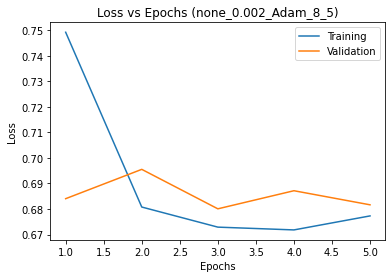

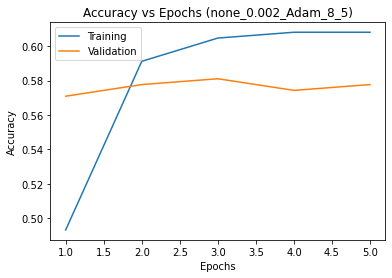

For Testing:
Accuracy is 0.5472972972972973
Precision is 0.5472972972972973
Recall is 0.5472972972972973
F1 Score is 0.5472972972972973


In [66]:
c = {
    'attention_freeze' : 'none',
    'lr' : 0.002,
    'optimizer' : 'Adam',
    'batch_size' : 8,
    'epochs' : 5
}

mm = MyModelClass(c)

try:
    mm = MyModelClass.load_model(f'{os.path.join(weights_folder, str(mm))}')
except:
    mm.make(train_X, train_y, val_X, val_y, test_X, test_y)
    mm.train()

mm.plot_losses(True)
mm.plot_accuracies(True)
mm.evaluate_testing()

mm.save_model()

### Freezing 'All' layers of Attention

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:16<00:00, 99.35s/it]


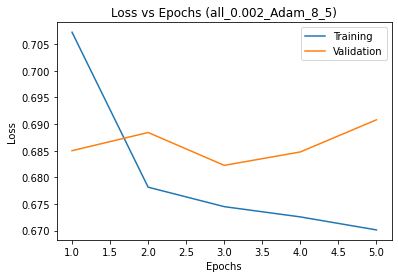

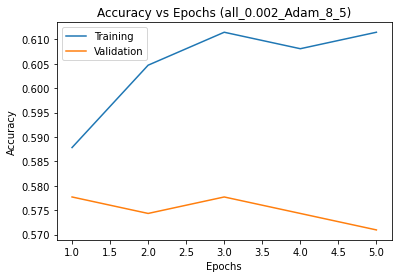

For Testing:
Accuracy is 0.5506756756756757
Precision is 0.5506756756756757
Recall is 0.5506756756756757
F1 Score is 0.5506756756756757


In [123]:
c = {
    'attention_freeze' : 'all',
    'lr' : 0.002,
    'optimizer' : 'Adam',
    'batch_size' : 8,
    'epochs' : 5
}

mm = MyModelClass(c)

try:
    mm = MyModelClass.load_model(f'{os.path.join(weights_folder, str(mm))}')
except:
    mm.make(train_X, train_y, val_X, val_y, test_X, test_y)
    mm.train()

mm.plot_losses(True)
mm.plot_accuracies(True)
mm.evaluate_testing()

mm.save_model()

### Freezing 'Some' layers of Attention

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:16<00:00, 99.29s/it]


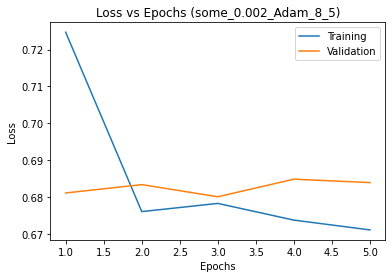

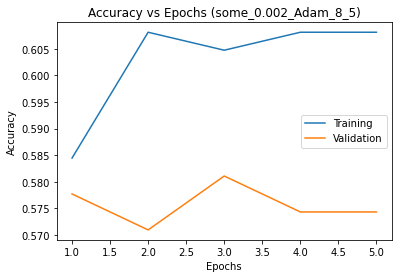

For Testing:
Accuracy is 0.5540540540540541
Precision is 0.5540540540540541
Recall is 0.5540540540540541
F1 Score is 0.5540540540540541


In [124]:
c = {
    'attention_freeze' : 'some',
    'lr' : 0.002,
    'optimizer' : 'Adam',
    'batch_size' : 8,
    'epochs' : 5
}

mm = MyModelClass(c)

try:
    mm = MyModelClass.load_model(f'{os.path.join(weights_folder, str(mm))}')
except:
    mm.make(train_X, train_y, val_X, val_y, test_X, test_y)
    mm.train()

mm.plot_losses(True)
mm.plot_accuracies(True)
mm.evaluate_testing()

mm.save_model()

### Differernt Combination of Learning Rate and Optimizers

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:17<00:00, 99.47s/it]


For learning rate = 0.001 and optimizer = Adam : 


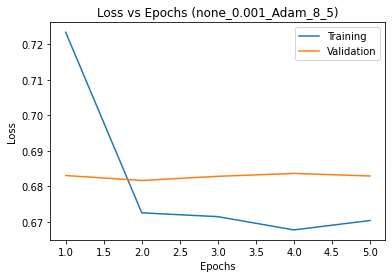

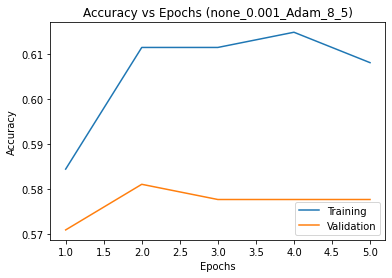

For Testing:
Accuracy is 0.5574324324324325
Precision is 0.5574324324324325
Recall is 0.5574324324324325
F1 Score is 0.5574324324324325


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:11<00:00, 98.38s/it]


For learning rate = 0.001 and optimizer = SGD : 


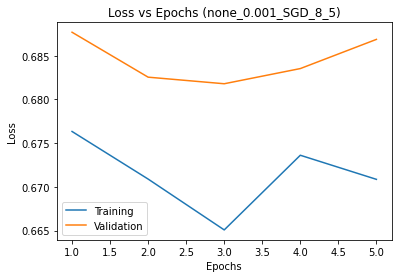

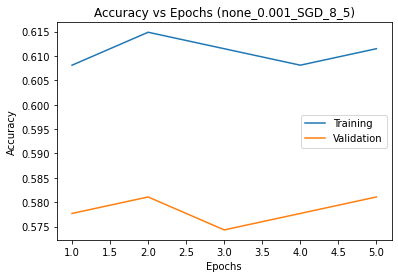

For Testing:
Accuracy is 0.5506756756756757
Precision is 0.5506756756756757
Recall is 0.5506756756756757
F1 Score is 0.5506756756756757


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:10<00:00, 98.15s/it]


For learning rate = 0.01 and optimizer = Adam : 


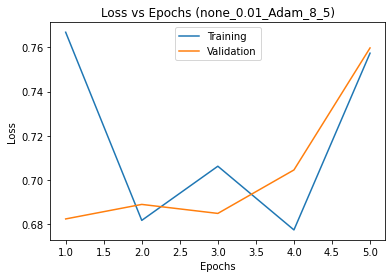

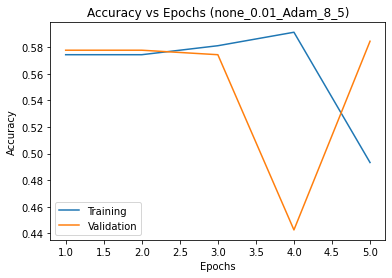

For Testing:
Accuracy is 0.5540540540540541
Precision is 0.5540540540540541
Recall is 0.5540540540540541
F1 Score is 0.5540540540540541


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:12<00:00, 98.48s/it]


For learning rate = 0.01 and optimizer = SGD : 


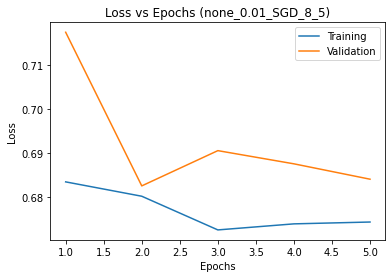

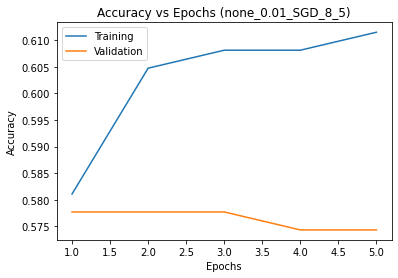

For Testing:
Accuracy is 0.5574324324324325
Precision is 0.5574324324324325
Recall is 0.5574324324324325
F1 Score is 0.5574324324324325


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:06<00:00, 97.28s/it]


For learning rate = 0.1 and optimizer = Adam : 


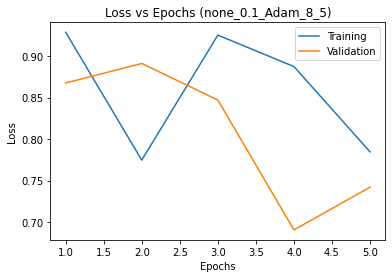

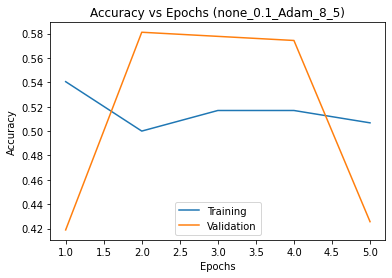

For Testing:
Accuracy is 0.44594594594594594
Precision is 0.44594594594594594
Recall is 0.44594594594594594
F1 Score is 0.44594594594594594


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [08:14<00:00, 98.82s/it]


For learning rate = 0.1 and optimizer = SGD : 


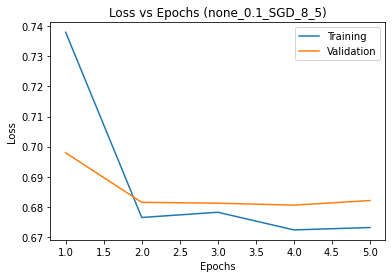

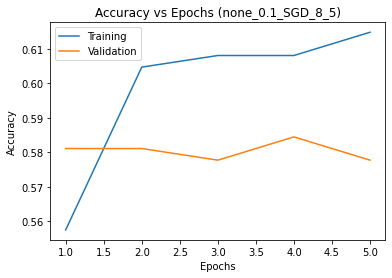

For Testing:
Accuracy is 0.5540540540540541
Precision is 0.5540540540540541
Recall is 0.5540540540540541
F1 Score is 0.5540540540540541


In [140]:
for lr in (1e-3, 1e-2, 1e-1) :
    for opt in ('Adam', 'SGD') :
        c = {
            'attention_freeze' : 'none',
            'lr' : lr,
            'optimizer' : opt,
            'batch_size' : 8,
            'epochs' : 5
        }

        mm = MyModelClass(c)

        try:
            mm = MyModelClass.load_model(f'{os.path.join(weights_folder, str(mm))}')
        except:
            mm.make(train_X, train_y, val_X, val_y, test_X, test_y)
            mm.train()

        print(f"For learning rate = {lr} and optimizer = {opt} : ")

        mm.plot_losses(True)
        mm.plot_accuracies(True)
        mm.evaluate_testing()

        mm.save_model()